In [31]:
import numpy as np
import arviz as az
import math
# import pymc3 as pm
import pickle
import matplotlib.pyplot as plt
from google.protobuf import text_format
from scipy.stats import multivariate_normal as mvn
from scipy.stats import skewnorm
from scipy.stats import norm
from scipy.interpolate import griddata
import csv
import random
import pandas as pd
from itertools import product
import statistics as stat
from sklearn.decomposition import TruncatedSVD


In [32]:
def multivariate_t_rvs(m, S, df=np.inf, n=1):
    '''generate random variables of multivariate t distribution
    Parameters
    ----------
    m : array_like
        mean of random variable, length determines dimension of random variable
    S : array_like
        square array of covariance  matrix
    df : int or float
        degrees of freedom
    n : int
        number of observations, return random array will be (n, len(m))
    Returns
    -------
    rvs : ndarray, (n, len(m))
        each row is an independent draw of a multivariate t distributed
        random variable
    '''
    m = np.asarray(m)
    d = len(m)
    if df == np.inf:
        x = 1.
    else:
        x = np.random.chisquare(df, n)/df
    z = np.random.multivariate_normal(np.zeros(d),S,(n,))
    return m + z/np.sqrt(x)[:,None]   # same output format as random.multivariate_normal


# Generate data

assuming delta = I identical for all clusters

In [33]:
def generate_etas(mus, deltas_cov, cluster_alloc):
    np.random.seed(seed=233423)
    #out = np.vstack([[mvn.rvs(mean = mus[i,:], cov = deltas_cov) for i in cluster_alloc]])
    out = np.vstack([multivariate_t_rvs(m = mus[i,:], S = deltas_cov, df = 3)[0] for i in cluster_alloc])

    return out

def generate_data(Lambda, etas, sigma_bar_cov):
    np.random.seed(seed=233423)
    means = np.matmul(Lambda,etas.T)
    sigma_bar_cov_mat = np.diag(sigma_bar_cov)
    #out = np.vstack([multivariate_t_rvs(m = means[:,i], S = sigma_bar_cov_mat, df = 3)[0] for i in range(etas.shape[0])])
    out = np.vstack([[mvn.rvs(mean = means[:,i], cov = sigma_bar_cov_mat) for i in range(etas.shape[0])]])

    return out

def create_lambda(p,d):
    #if p % d != 0:
      #  raise ValueError("Non compatible dimensions p and d: p={0}, d={1}".format(p,d))
    
    h = math.ceil(p/d)
    Lambda=np.zeros((p,d))
    for i in range(d-1):
        Lambda[i*h:i*h+h,i] = np.ones(h)
    
    Lambda[(d-1)*h:,d-1] = np.ones(p-(d-1)*h)
    return Lambda

def create_mus(d,M,dist):
    mus = np.zeros((M,d))
    tot_range = (M-1)*dist 
    max_mu = tot_range/2
    for i in range(M):
        mus[i,:] = np.repeat(max_mu-i*dist, d)
        
    return mus

def create_cluster_alloc(n_pc,M):
    return np.repeat(range(M),n_pc)    

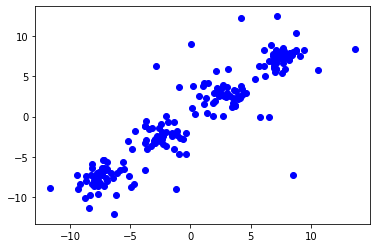

In [39]:
##### just to visualize the latent points for one setting
d=2
delta_cov = np.eye(d)
M=4
dist=5
mus = create_mus(d,M,dist)
n_percluster=50

cluster_alloc = create_cluster_alloc(n_percluster,M)
etas = generate_etas(mus, delta_cov, cluster_alloc)

plt.plot(etas[:,0],etas[:,1], 'bo')

In [41]:
random.seed(1234)

dist=5
p_s = [100, 200, 400]
d_s = [2, 5, 10]
M_s = [4, 8]
n_percluster_s = [50]

for p in p_s:
    sigma_bar_prec = np.repeat(2, p)
    sigma_bar_cov = 1/sigma_bar_prec
    for d in d_s:
        lamb = create_lambda(p,d)
        delta_cov = np.eye(d)
        for M in M_s:
            mus = create_mus(d,M,dist)
            for n_percluster in n_percluster_s:                
                cluster_alloc = create_cluster_alloc(n_percluster,M)
                etas = generate_etas(mus, delta_cov, cluster_alloc)
                data = generate_data(lamb, etas, sigma_bar_cov)
                #with open("datasets/stud_p_{0}_d_{1}_M_{2}_npc_{3}_data.csv".format(p,d,M,n_percluster),"w+") as my_csv:
                    csvWriter = csv.writer(my_csv, delimiter=',')
                    csvWriter.writerows(data)


